In [1]:
import numpy as np
import matplotlib.pyplot as plt

The goal of this notebook is to create a dataset of simple synthetic STM-like features, and use these as inputs to an artificial neural network (ANN) along with corresponding labels to return output successfully labeling positions of the features. 

This approach has allows automatic generation for the label data conforming to the labeling scheme I had in mind and I can vary the size of the dataset. Ultimately, this could be useful as a tool for exploring various aspects of an ML image problem.  

STM images of organic molecule self-assembly are generally highly-noisy (contrast difference artefacts, drift of microscope probe) and have low-dimensional feature space. Classes are things such as a few distinct rotational states, different molecules within a same image, the possibility of polymorphism in distinct domain packings.   

A typical STM image of organic molecule self-assembly:

<img src="STM.jpg" alt="Alt text that describes the graphic" style="width: 300px;" />

### I. Creating data

Create a dataset of randomly placed, noised features and use this for ANN input.  

In [2]:
def maketriangle():
     result=np.zeros((10,10))
     result[5,2]=30*np.random.randn()+130
     result[4,3]=30*np.random.randn()+130
     result[5,3]=30*np.random.randn()+130
     result[6,3]=30*np.random.randn()+130
     result[3,4]=30*np.random.randn()+130
     result[4,4]=30*np.random.randn()+130
     result[5,4]=30*np.random.randn()+130
     result[6,4]=30*np.random.randn()+130
     result[7,4]=30*np.random.randn()+130
     return result

In [3]:
def dataset_create(N):
    j=0
    jmax=N
    zeros = dict()
    noised_im = dict()
    while j<jmax:
        try:
            pic = np.zeros((50,50))
            trg = maketriangle()
            startx = int(5*np.random.randn()+25)
            starty = int(5*np.random.randn()+25)
            pic[startx:startx+10,starty:starty+10]+=trg
            zeros[j]=('zeros{}'.format(j),pic)
            noise = 20*np.random.randn(50,50)+100
            noise[startx:startx+10,starty:starty+10]+=trg
            noised_im[j] = ('noised_im{}'.format(j),noise)
            j+=1
        except ValueError:
            pass
    return zeros, noised_im

In [4]:
zeros, noised_im = dataset_create(10**4) 

In [5]:
y_train_255=dict()
for x in zeros:
    pic=zeros[x][1]
    pic[pic>0]=255
    y_train_255[x]=('y_train_0{}'.format(x),pic)

In [6]:
x_train = []
for x in noised_im:
    x_train.append(noised_im[x][1])
y_train = []
for x in y_train_255:
    y_train.append(y_train_255[x][1])

x_tot = np.concatenate(np.asarray(x_train)).reshape(10**4,50,50)
y_tot = np.concatenate(np.asarray(y_train)).reshape(10**4,50,50)

train_size = 9500
x_train,y_train = x_tot[:train_size,:,:],y_tot[:train_size,:,:]
x_test,y_test = x_tot[train_size:,:,:],y_tot[train_size:,:,:]

In [7]:
# Standardizing dataset to improve ANN performance
from sklearn.preprocessing import StandardScaler
x_scale = StandardScaler()

x_train = x_scale.fit_transform(x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_test = x_scale.fit_transform(x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2]))

### II. ANN

In [8]:
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [9]:
image_size = 50*50

model = Sequential()

# The input layer requires the special input_shape parameter which should match
# the shape of our training data.
model.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,)))
model.add(Dense(units=image_size, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                80032     
_________________________________________________________________
dense_2 (Dense)              (None, 2500)              82500     
Total params: 162,532
Trainable params: 162,532
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train.reshape(9500,2500), batch_size=100, epochs=20, verbose=False, validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test.reshape(500,50*50), verbose=False)

Instructions for updating:
Use tf.cast instead.


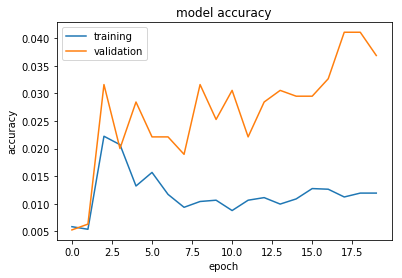

Test loss: 7.09e+03
Test accuracy: 0.036


In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

### III. Results
Visually the correct positions are returned for the first 20 images. Not working in this direction right now, so am satisfied with this basic result for this notebook. 

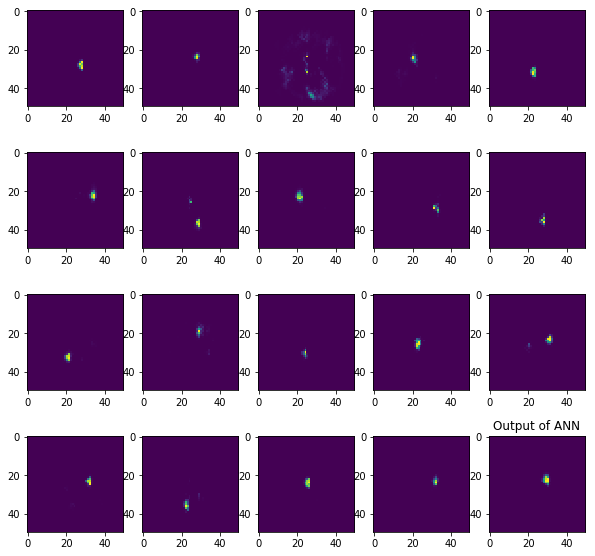

In [12]:
output = model.predict(x_test)
output = output.reshape(500,50,50)
fig,ax = plt.subplots(4,5,figsize=(10,10))
fig.suptitle('Output', fontsize=16)
i=0
for x in range(4):
    for y in range(5):
        ax[x,y].imshow(output[i,:,:])
        i+=1
plt.show()    

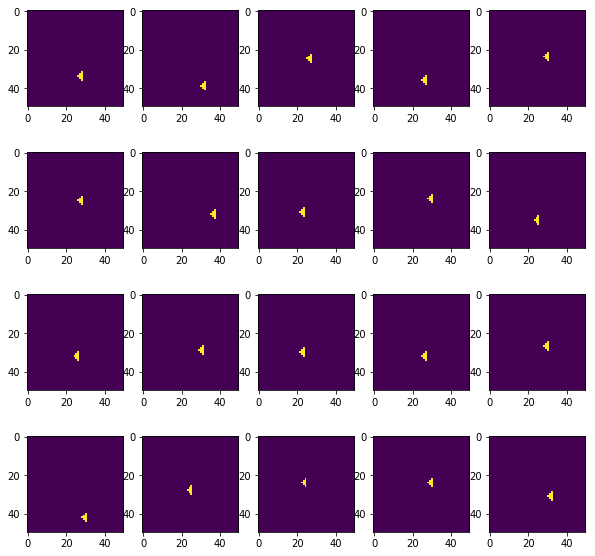

In [13]:
fig,ax = plt.subplots(4,5,figsize=(10,10))
i=0
for x in range(4):
    for y in range(5):
        ax[x,y].imshow(y_test[i,:,:])
        i+=1
plt.show()    

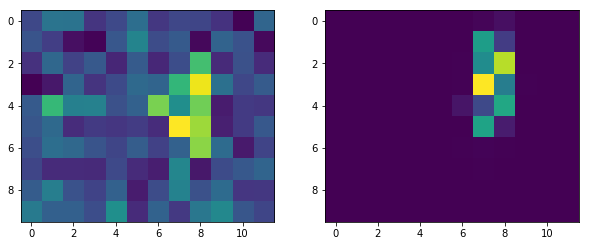

In [16]:
fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(x_test.reshape(500,50,50)[0][30:40,20:32])
ax[1].imshow(output[0][30:40,20:32])